In [1]:
import gensim
import nltk
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import json

In [2]:
with open("chunk_1.json", "r") as file:
    chunk_1 = [json.loads(line) for line in file]


nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/anna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/anna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:


def is_meaningful_word(word):
    """Check if the word has meaning using WordNet."""
    return wordnet.synsets(word)  

from nltk.stem import SnowballStemmer
from gensim.utils import simple_preprocess


def preprocess(text, stop_words, stemmer_language="english"):
    """
    Tokenizes and preprocesses the input text, removing stopwords, short tokens, and applying stemming.

    Parameters:
        text (str): The input text to preprocess.
        stop_words (set): A set of stopwords to be removed from the text.
        stemmer_language (str): The language to use for stemming (default is English).

    Returns:
        list: A list of preprocessed tokens.
    """
    if not text:
        raise ValueError("Input text is empty or invalid.")

    # Initialize the stemmer
    stemmer = SnowballStemmer(stemmer_language)

    # Tokenize, filter, and stem tokens
    result = []
    for token in simple_preprocess(text, deacc=True):
        if token not in stop_words and is_meaningful_word(token) and len(token) > 3:
            stemmed_token = stemmer.stem(token)
            result.append(stemmed_token)
    return result


def extract_topics(text, num_topics=2, num_words=2, passes=15):
    """
    Extracts topics from the input text using LDA and visualizes them with pyLDAvis.

    Parameters:
        text (str): The input text to extract topics from.
        num_topics (int): The number of topics to extract.
        num_words (int): The number of words to display for each topic.
        passes (int): The number of passes for LDA training.
    Returns:
        list: A list of tuples containing the topic keywords and their weights.
    """
    if not text:
        raise ValueError("Input text is empty or invalid.")

    stop_words = set(stopwords.words('english'))

 
    tokens = preprocess(text, stop_words)
    if not tokens:
        raise ValueError("Preprocessing resulted in no valid tokens.")

 
    dictionary = corpora.Dictionary([tokens])
    corpus = [dictionary.doc2bow(tokens)]


    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes)

 
    topics = lda_model.print_topics(num_topics=num_topics, num_words=num_words)
    print("Extracted Topics:")
  
    for topic_num, topic in enumerate(topics, 1):
       
        print(f"Topic {topic_num}: {topic}")

   
    return topics

In [4]:
import csv

output_data = {}
distinct_topics = set()  

def parse_topics(topics):

    parsed_topics = []
    for topic in topics:
        if isinstance(topic, tuple) and len(topic) == 2:
            _, topic_str = topic
         
            words = [word.split('"')[1] for word in topic_str.split(" + ") if '"' in word]
            parsed_topic = " + ".join(words)
            parsed_topics.append(parsed_topic)
            distinct_topics.add(parsed_topic)  
    return list(set(parsed_topics))  

for i, element in enumerate(chunk_1):
    print(f"Analysis of the element {i + 1}...")
    sample_text = element.get("normalizedBody", "").strip()
    if not sample_text:
        print(f"The element {i + 1} is empty")
        continue

    try:
        topics = extract_topics(sample_text, num_topics=2, num_words=1, passes=15)
        if topics:
            output_data[i] = {
                "author": element.get("author", ""),
                "subreddit": element.get("subreddit", ""),
                "subreddit_id": element.get("subreddit_id", ""),
                "topics": "; ".join(parse_topics(topics))
            }
    except ValueError as e:
        print(f"Erreur lors de l'analyse de l'élément {i + 1} : {e}")


output_file_csv = "extracted_topics.csv"
with open(output_file_csv, mode="w", newline="", encoding="utf-8") as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=["author", "subreddit", "subreddit_id", "topics"])
    writer.writeheader()
    writer.writerows(output_data.values())


output_file_txt = "distinct_topics.txt"
with open(output_file_txt, mode="w", encoding="utf-8") as txt_file:
    txt_file.write("\n".join(sorted(distinct_topics))) 

print(f"Results have been uploaded to {output_file_csv}.")
print(f"Distinct topics have been uploaded to {output_file_txt}.")


Analyse de l'élément 1...
Extracted Topics:
Topic 1: (0, '0.037*"timekeeping"')
Topic 2: (1, '0.014*"timekeeping"')
Analyse de l'élément 2...
Extracted Topics:
Topic 1: (0, '0.020*"term"')
Topic 2: (1, '0.032*"personal"')
Analyse de l'élément 3...
Extracted Topics:
Topic 1: (0, '0.018*"street"')
Topic 2: (1, '0.037*"read"')
Analyse de l'élément 4...
Extracted Topics:
Topic 1: (0, '0.024*"plus"')
Topic 2: (1, '0.012*"plus"')
Analyse de l'élément 5...
Extracted Topics:
Topic 1: (0, '0.066*"item"')
Topic 2: (1, '0.011*"item"')
Analyse de l'élément 6...
Extracted Topics:
Topic 1: (0, '0.062*"nail"')
Topic 2: (1, '0.023*"nails"')
Analyse de l'élément 7...
Extracted Topics:
Topic 1: (0, '0.018*"directions"')
Topic 2: (1, '0.045*"directions"')
Analyse de l'élément 8...
Extracted Topics:
Topic 1: (0, '0.020*"roll"')
Topic 2: (1, '0.031*"mind"')
Analyse de l'élément 9...
Extracted Topics:
Topic 1: (0, '0.030*"concern"')
Topic 2: (1, '0.018*"concern"')
Analyse de l'élément 10...
Extracted Topics

In [5]:
from transformers import BertTokenizer, BertModel
import torch


tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertModel.from_pretrained("bert-base-multilingual-cased")


with open("distinct_topics.txt", "r", encoding="utf-8") as file:
    words = [line.strip() for line in file]


embeddings = []
for word in words:
    inputs = tokenizer(word, return_tensors="pt", truncation=True)
    outputs = model(**inputs)
    # Utilisez la dernière couche cachée moyenne comme embedding
    embedding = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    embeddings.append(embedding)


In [7]:
from sklearn.cluster import KMeans
import numpy as np
import json


embedding_matrix = np.vstack(embeddings)

num_clusters = 100
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embedding_matrix)

clusters = kmeans.labels_

# Grouping words by cluster
grouped_words = {i: [] for i in range(num_clusters)}
for word, cluster_id in zip(words, clusters):
    grouped_words[cluster_id].append(word)

# Saving clusters in a json file
output_file_json = "clusters_100.json"
with open(output_file_json, mode="w", encoding="utf-8") as json_file:
    json.dump(grouped_words, json_file, ensure_ascii=False, indent=4)


for cluster_id, cluster_words in grouped_words.items():
    print(f"Cluster {cluster_id}: {', '.join(cluster_words)}")



/home/anna/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0: admiral, army, attachments, baron, battalion, battleship, cavalry, chef, chief, chiefs, colonel, commander, earl, emperor, firefighters, firefly, general, helicopter, infantry, inspector, knight, lord, lords, mayor, officer, officers, patriot, president, prince, shogun, soldier, soldiers, troops, warrior, warriors
Cluster 1: adding, allow, apply, assume, assumption, begin, come, compare, continue, define, depends, derived, empty, ensure, enter, example, examples, exist, exists, finally, function, give, giver, installed, instance, otherwise, prime, print, procedure, proceeded, puts, read, relevant, replace, represents, require, result, return, right, satisfied, scheme, sequence, shown, statement, suppose, therefore, tills, using, values, yields
Cluster 2: absolutely, accidentally, aggressively, alive, almost, already, always, arrange, badly, basically, bloody, breathing, closer, completely, constantly, deadly, deeper, deepest, deeply, definitely, delusions, disheartening, dis

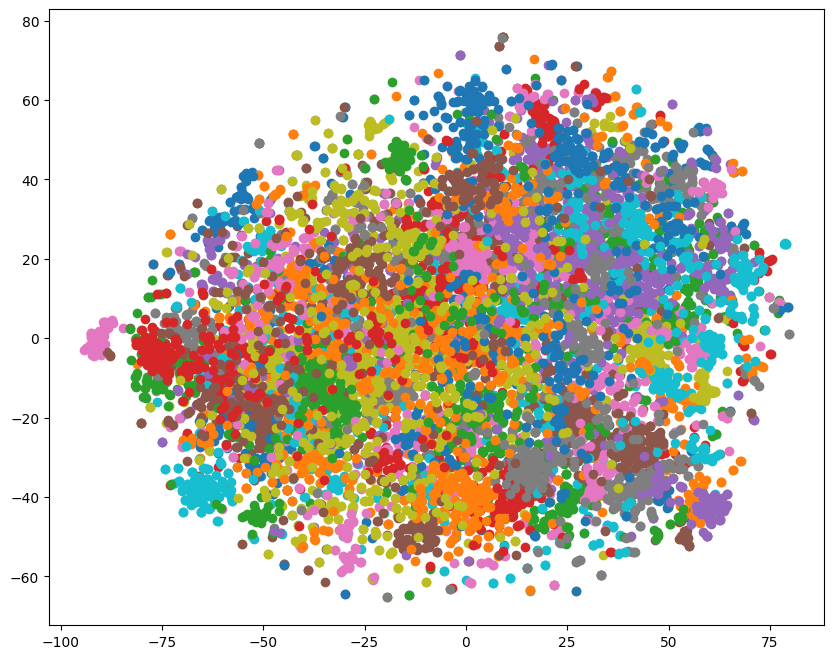

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embedding_matrix)

plt.figure(figsize=(10, 8))
for cluster_id in range(num_clusters):
    cluster_points = reduced_embeddings[clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
plt.show()


In [12]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/anna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/anna/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /home/anna/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/anna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
import csv
import json


csv_file_path = "extracted_topics.csv" 
json_file_path = "clusters.json"  
output_csv_file_path = "posts_with_clusters.csv" 


with open(json_file_path, "r", encoding="utf-8") as json_file:
    clusters = json.load(json_file)


topic_to_cluster = {}
for cluster_id, topics in clusters.items():
    for topic in topics:
        topic_to_cluster[topic] = cluster_id


with open(csv_file_path, mode="r", encoding="utf-8") as csv_file:
    reader = csv.DictReader(csv_file)
    posts = list(reader)


for post in posts:

    post_topics = post["topics"].split(";")  
    cluster_ids = [topic_to_cluster.get(topic.strip(), "Unknown") for topic in post_topics]
    post["cluster"] = ",".join(set(cluster_ids)) 


with open(output_csv_file_path, mode="w", encoding="utf-8", newline="") as output_csv_file:
    fieldnames = list(posts[0].keys())
    writer = csv.DictWriter(output_csv_file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(posts)

print(f"Name of the CSV file : {output_csv_file_path}")


Le fichier CSV avec les clusters a été enregistré sous : posts_with_clusters.csv


In [1]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  


[nltk_data] Downloading package wordnet to /home/anna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/anna/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
import pandas as pd
import json
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import os


def classify_documents(texts, predefined_topics, model_name="all-MiniLM-L12-v2", top_n=2, batch_size=512, output_csv_path="final_topics_2.csv"):
    """
    Classifies a list of documents in batches by their similarity to predefined topics and saves results incrementally.

    Parameters:
        texts (list of str): The input documents to classify.
        predefined_topics (list of str): A list of predefined topics.
        model_name (str): The name of the SentenceTransformer model to use.
        top_n (int): The number of top similar topics to return.
        batch_size (int): The size of each batch.
        output_csv_path (str): The path to the output CSV file.

    Returns:
        None: Results are written incrementally to the output CSV file.
    """
    if not texts or not predefined_topics:
        raise ValueError("Texts and predefined topics must not be empty.")
    if top_n <= 0:
        raise ValueError("top_n must be greater than 0.")

    # Load the embedding model
    model = SentenceTransformer(model_name)

    # Compute embeddings for predefined topics once
    topic_embeddings = model.encode(predefined_topics, convert_to_tensor=True)

    num_batches = (len(texts) + batch_size - 1) // batch_size  # Calculate total number of batches

    # Check if the output file exists, and write the header only if it doesn't
    write_header = not os.path.exists(output_csv_path)

    for batch_idx in range(num_batches):
        print(f"Processing batch {batch_idx + 1}/{num_batches}")
        batch_texts = texts[batch_idx * batch_size: (batch_idx + 1) * batch_size]
        text_embeddings = model.encode(batch_texts, convert_to_tensor=True)

        # Compute cosine similarity for the batch
        similarity_matrix = cosine_similarity(text_embeddings.cpu().numpy(), topic_embeddings.cpu().numpy())

        classified_data = []
        for i, text in enumerate(batch_texts):
            topic_scores = {predefined_topics[j]: similarity_matrix[i][j] for j in range(len(predefined_topics))}
            sorted_topics = sorted(topic_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
            topic1, topic2 = sorted_topics[0][0], (sorted_topics[1][0] if len(sorted_topics) > 1 else None)
            classified_data.append({"topic1": topic1, "topic2": topic2})

        # Convert to DataFrame and append to CSV
        classified_df = pd.DataFrame(classified_data)

        with open(output_csv_path, "a") as f:
            classified_df.to_csv(f, header=write_header, index=False)

        write_header = False  # Ensure header is only written once

        print(f"Batch {batch_idx + 1}/{num_batches} processed and saved.")


input_json_path = "chunk1.json"
output_csv_path = "final_topics_2.csv"


with open(input_json_path, "r") as f:
    data = [json.loads(line) for line in f]


data_df = pd.DataFrame(data)


documents = data_df["content"].tolist()

# Topics
topics = [
    "Science", "Technology", "Environment", "Politics", "Religion", 
    "Philosophy", "Art", "Literature", "Music", "Education", "History", 
    "Health", "Psychology", "Economics", "Democracy", "Freedom", "Gender", 
    "Family", "Relationship", "Sexuality", "Emotion", "Nature", 
    "Animals", "Sports", "Travel", "Humor", "Violence", "Game", "War",
    "Fashion", "Industry", "Food", "Country", "Geography", "Body", "Justice",
    "Society"
]

# Classify and save incrementally
classify_documents(documents, topics, top_n=2, batch_size=512, output_csv_path=output_csv_path)
